# Mask R-CNN - Acute Lymphoblastic Leukemia L1 Trained Model

Code and visualizations for test, debug, and evaluate the Mask R-CNN model.

Modified for Acute Lymphoblastic Leukemia L1 by Mahatma Wisesa

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

In [2]:
# CUSTOM

# from samples.balloon import balloon
import balloon_colab9_2
balloon = balloon_colab9_2

# Root directory of the project
ROOT_DIR = os.path.abspath(r"C:\Users\Mahatma Ageng Wisesa\Desktop\Mask RCNN TF2.0\Mask_RCNN\samples\custom\root")
# BALLON_WEIGHTS_PATH = ROOT_DIR+r"\.weights\original\mask_rcnn_cell_0220 (logs-28-oct-original (220 epoch, colab10_5, con=0.7).h5"
BALLON_WEIGHTS_PATH = ROOT_DIR+r"\.weights\processed\mask_rcnn_cell_0220 (logs-22-oct-processed (220 epoch, balloon_colab10_2, con=0.85)).h5"

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
 # TODO: update this path

## Configurations

In [3]:
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "dataset4") # dataset 3 --> (original) ; dataset 4 --> (processed)

In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # setting terbaik
    DETECTION_MIN_CONFIDENCE = 0.4
    
    DETECTION_NMS_THRESHOLD = 0.2 
    RPN_NMS_THRESHOLD = 0.2 
    
#     DETECTION_NMS_THRESHOLD = 0.4
#     RPN_NMS_THRESHOLD = 0.35 
    
    USE_MINI_MASK = False

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.4
DETECTION_NMS_THRESHOLD        0.2
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [7]:
# Load validation dataset
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

[1, 2]; [1, 1, 2]; [1, 2]; [2, 1, 2]; [2, 1]; [2, 1]; [1, 2]; [2]; [2]; [1, 2]; [2]; [2]; [2]; [2]; [1, 2]; [2]; [2]; [2]; [2]; [2]; [2]; [2]; [2]; [1, 2]; [2]; [2]; [2]; [2]; [2]; [2]; [2]; [2]; [2]; [1, 2, 1]; [2]; [2]; [2]; [1, 2]; [2]; [2, 2]; [2, 1]; [1, 2, 2]; [1, 1]; [1, 1]; [1, 1]; [1, 1]; [1, 1]; [1, 1]; [1, 1]; [1, 1]; [1]; [1, 1]; [1]; [1]; [1, 1]; [1]; [1]; [1]; [1]; [1, 1]; [1, 1]; [1]; [1]; [1, 1]; [1]; [1, 1, 1, 1]; [1]; [1]; [1]; Images: 69
Classes: ['BG', 'limfoblas', 'non-limfoblas']


## Load Model

In [8]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


In [9]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", BALLON_WEIGHTS_PATH)
model.load_weights(BALLON_WEIGHTS_PATH, by_name=True)

Loading weights  C:\Users\Mahatma Ageng Wisesa\Desktop\Mask RCNN TF2.0\Mask_RCNN\samples\custom\root\.weights\processed\mask_rcnn_cell_0220 (logs-22-oct-processed (220 epoch, balloon_colab10_2, con=0.85)).h5


## Evalutaion

In [10]:
def evaluate_model(dataset, model, cfg):
    APs = list(); 
    F1_scores = list(); 
    for image_id in dataset.image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id)
#         scaled_image = mold_image(image, cfg)
        sample = np.expand_dims(image, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        F1_scores.append((2* (np.mean(precisions) * np.mean(recalls)))/(np.mean(precisions) + np.mean(recalls)))
        APs.append(AP)
    
    mAP = np.mean(APs)
    F1_score = np.mean(F1_scores)
    return round(mAP, 4), F1_score

In [11]:
# evaluate_model(dataset, model, config)

## Run Detection

image ID: cell.ALL1.1.49 L B (rescaled).jpg (4) C:\Users\Mahatma Ageng Wisesa\Desktop\Mask RCNN TF2.0\Mask_RCNN\samples\custom\root\dataset4\val\ALL1.1.49 L B (rescaled).jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  222.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  118.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:  571.00000  max:  929.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


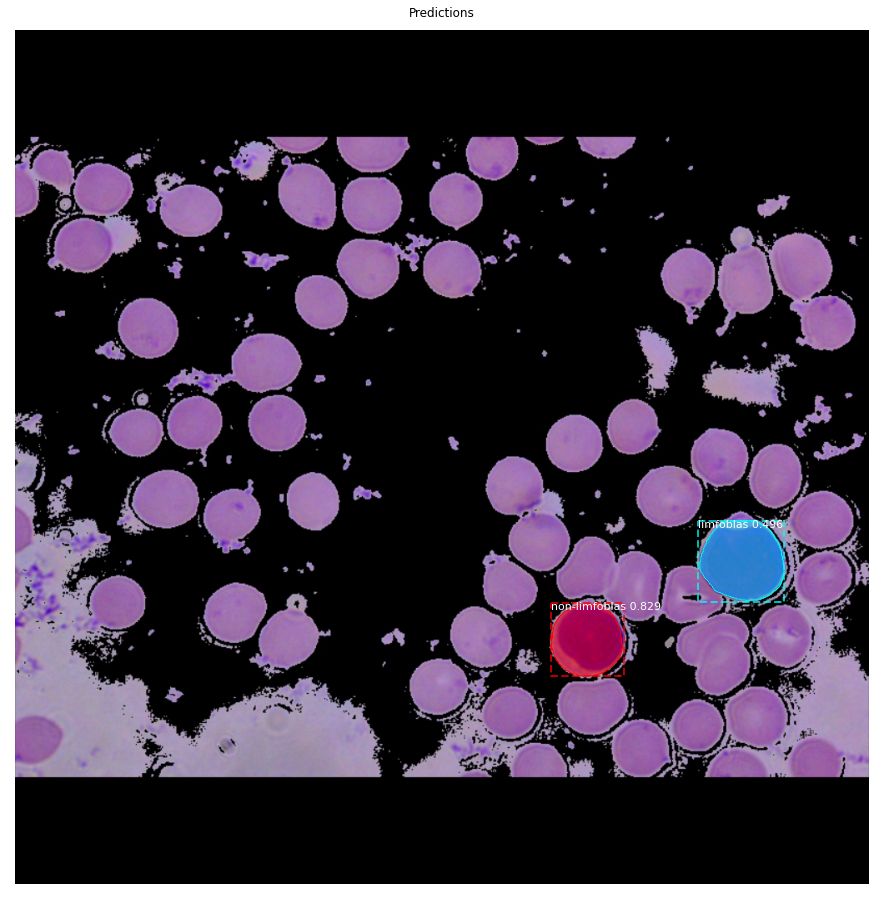

In [15]:
image_id = 4

# image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Color Splash

This is for illustration. You can call `balloon.py` with the `splash` option to get better images without the black padding.

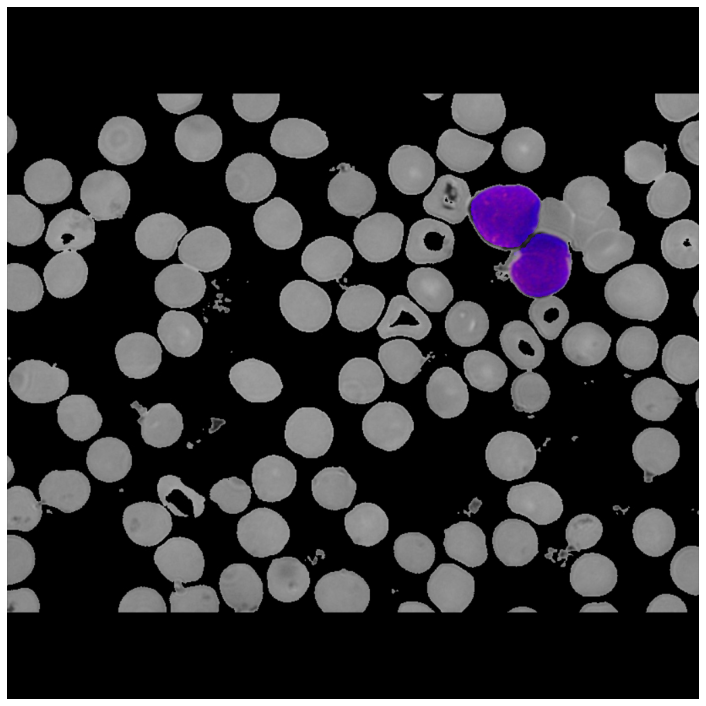

In [94]:
splash = balloon.color_splash(image, r['masks'])
display_images([splash], cols=1)

## Testing with specific images (test-set)

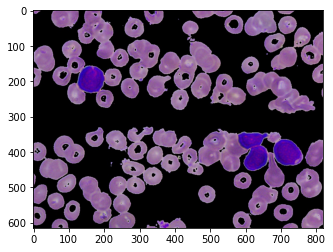

In [95]:
import cv2 as cv

# image_name = "ALL1.1.1752 B B B B (rescaled).jpg"
image_name = "ALL1.1.1752 B B B B (rescaled) (Masked WC).jpg" 

# "ALL1.1.1731 B B (rescaled).jpg" 
# "ALL1.1.1752 B B B B (rescaled).jpg" 
#"ALL1.1.1066 L (rescaled).jpg"#"ALL1.1.1714 B B (rescaled).jpg" #""ALL1.1.35 B L(BAWAH) (rescaled).jpg" # ALL1.1.1714 B B (rescaled) -> tidak ke detect 1

# image = cv.imread("test-v2 (org)\\"+image_name)
image = cv.imread("test-v2 (s)\\"+image_name)

image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.imshow(image)

Processing 1 images
image                    shape: (615, 820, 3)         min:    0.00000  max:  222.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  115.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:  260.00000  max:  842.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


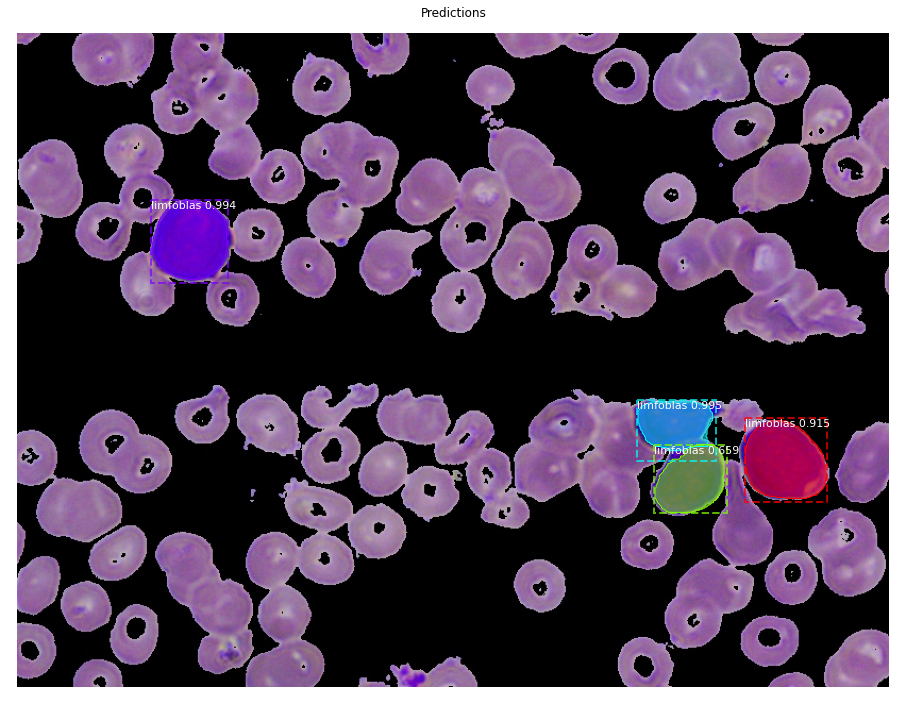

In [96]:
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

plt.savefig('your_desired_path_to_image2.jpg', bbox_inches='tight')

In [97]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 3)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 3, 4)       min:   -6.90550  max:    4.64792  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
4 detections: ['limfoblas' 'limfoblas' 'limfoblas' 'limfoblas']


In [98]:
detected_cells = np.array(dataset.class_names)[det_class_ids]
cells = {
    "limfoblas":0,
    "non-limfoblas":0
}
for cell in detected_cells:
    cells[cell] += 1
print(image_name)
print(cells)

ALL1.1.1752 B B B B (rescaled) (Masked WC).jpg
{'limfoblas': 4, 'non-limfoblas': 0}


## Predict for all test images

In [103]:
from os import listdir
from os.path import isfile, join
mypath = "val-processed"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)
print(len(onlyfiles))

['ALL1.1.1001 L (rescaled).jpg', 'ALL1.1.1003 S (rescaled).jpg', 'ALL1.1.1011 L (rescaled).jpg', 'ALL1.1.1016 L (rescaled).jpg', 'ALL1.1.102 M (rescaled).jpg', 'ALL1.1.1023 B L (rescaled).jpg', 'ALL1.1.1025 L (rescaled).jpg', 'ALL1.1.1056 S (rescaled).jpg', 'ALL1.1.1058 B L (rescaled).jpg', 'ALL1.1.107 STAB (rescaled).jpg', 'ALL1.1.1077 S (rescaled).jpg', 'ALL1.1.1079 S (rescaled).jpg', 'ALL1.1.1091 L B (rescaled).jpg', 'ALL1.1.1096 B L (rescaled).jpg', 'ALL1.1.1097 S (rescaled).jpg', 'ALL1.1.1118 L B (rescaled).jpg', 'ALL1.1.1121 S (rescaled).jpg', 'ALL1.1.1122 B L (rescaled).jpg', 'ALL1.1.1127 S B (rescaled).jpg', 'ALL1.1.1129 L B B B (rescaled).jpg', 'ALL1.1.1137 METAMIELOSIT B (rescaled).jpg', 'ALL1.1.1155 B L (rescaled).jpg', 'ALL1.1.1160 B L (rescaled).jpg', 'ALL1.1.1174 B L (rescaled).jpg', 'ALL1.1.1194 EOSINOFIL B (rescaled).jpg', 'ALL1.1.1196 B B L B (ATAS) (rescaled).jpg', 'ALL1.1.1199 L B (rescaled).jpg', 'ALL1.1.1224 B B S (rescaled).jpg', 'ALL1.1.1265 L(ATAS) B (rescaled).

In [104]:
import pandas as pd

def predict(image_path, filenames, save_path):
    image_array = {filename:cv.imread(image_path+"\\"+filename) for filename in filenames}
    image_array_RGB = {filename:cv.cvtColor(image, cv.COLOR_BGR2RGB) for (filename, image) in image_array.items()}
#     print(image_array['ALL1.1.831 PROMONOSIT (rescaled).jpg'])
#     print(image_array_RGB['ALL1.1.831 PROMONOSIT (rescaled).jpg'])
    
    cells = {
    "limfoblas":0,
    "non-limfoblas":0
    }
    
    count = {
        "filename":[],
        "limfoblas":[],
        "non-limfoblas":[]
    }
    
    for (filename, image) in image_array_RGB.items():
#         plt.imshow(image)
        results = model.detect([image], verbose=1)
        
        # Display results
        ax = get_ax(1)
        r = results[0]
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                    dataset.class_names, r['scores'], ax=ax,
                                    title="Predictions")
        log("gt_class_id", gt_class_id)
        log("gt_bbox", gt_bbox)
        log("gt_mask", gt_mask)
        
        # Save predictions
        plt.savefig(save_path+"\\"+filename, bbox_inches='tight')
        
        # Get input and output to classifier and mask heads.
        mrcnn = model.run_graph([image], [
            ("proposals", model.keras_model.get_layer("ROI").output),
            ("probs", model.keras_model.get_layer("mrcnn_class").output),
            ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
            ("masks", model.keras_model.get_layer("mrcnn_mask").output),
            ("detections", model.keras_model.get_layer("mrcnn_detection").output),
        ])

        # Get detection class IDs. Trim zero padding.
        det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
        det_count = np.where(det_class_ids == 0)[0][0]
        det_class_ids = det_class_ids[:det_count]
        detections = mrcnn['detections'][0, :det_count]

#         print("{} detections: {}".format(
#             det_count, np.array(dataset.class_names)[det_class_ids]))
        
        detected_cells = np.array(dataset.class_names)[det_class_ids]
        
        image_count = {
            "limfoblas":0,
            "non-limfoblas":0
        }
        
        for cell in detected_cells:
            cells[cell] += 1
            image_count[cell] += 1
        
        count["filename"].append(filename)
        count["limfoblas"].append(image_count["limfoblas"])
        count["non-limfoblas"].append(image_count["non-limfoblas"])
        
        print("#"*50)
        print("# "+filename)
        print("# "+"-"*20)
        print("# Limfoblas :", image_count["limfoblas"])
        print("# Non-limfoblas :", image_count["non-limfoblas"])
        print("#"*50)
    
    df = pd.DataFrame(count)
    df.to_csv(save_path+"\\"+"cells_count.csv")
        
    print("##### Total Cells #####")
    print("Limfoblas :", cells["limfoblas"])
    print("Non-limfoblas :", cells["non-limfoblas"])

Processing 1 images
image                    shape: (615, 820, 3)         min:    0.00000  max:  232.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  126.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (3,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (3, 4)                min:   85.00000  max:  846.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 3)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 3, 4)       min:   -9.21150  max:    3.03824  float32
masks                    shap

gt_class_id              shape: (3,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (3, 4)                min:   85.00000  max:  846.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 3)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 3, 4)       min:   -9.21633  max:    3.76393  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00022  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32
##################################################
# ALL1.1.1025 L (rescaled).jpg
# --------------------
# Limfoblas : 0
# Non-limfoblas : 1
##################################################
Processing 1 images
image                    sh

KeyboardInterrupt: 

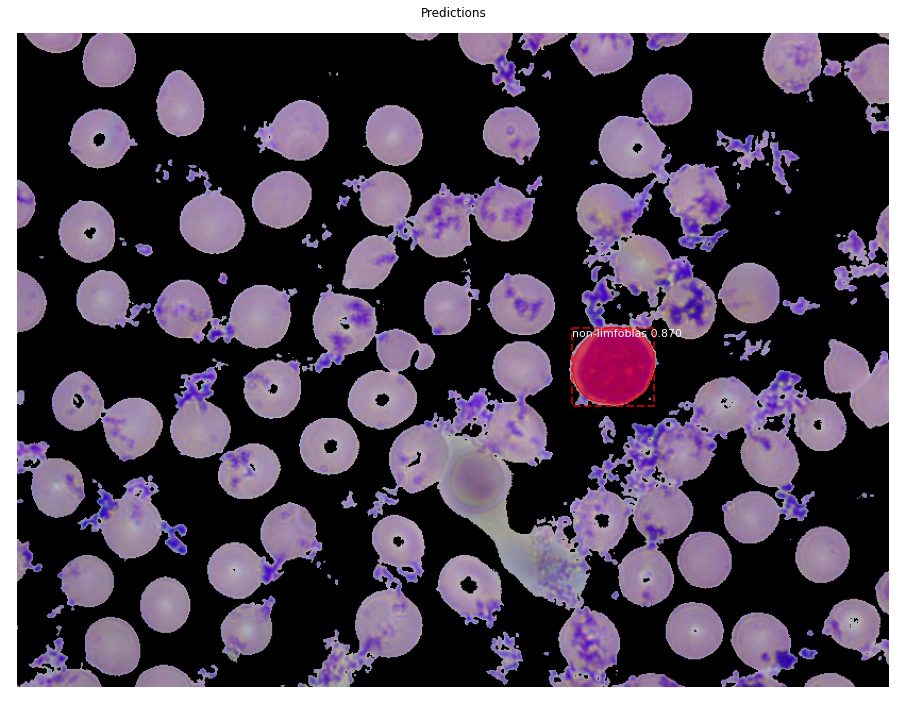

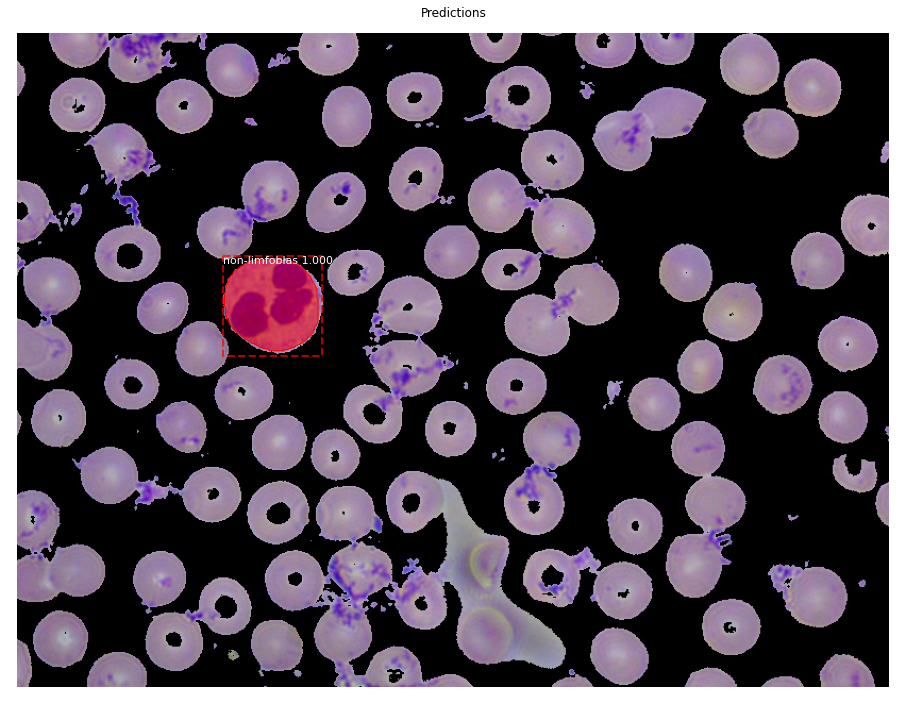

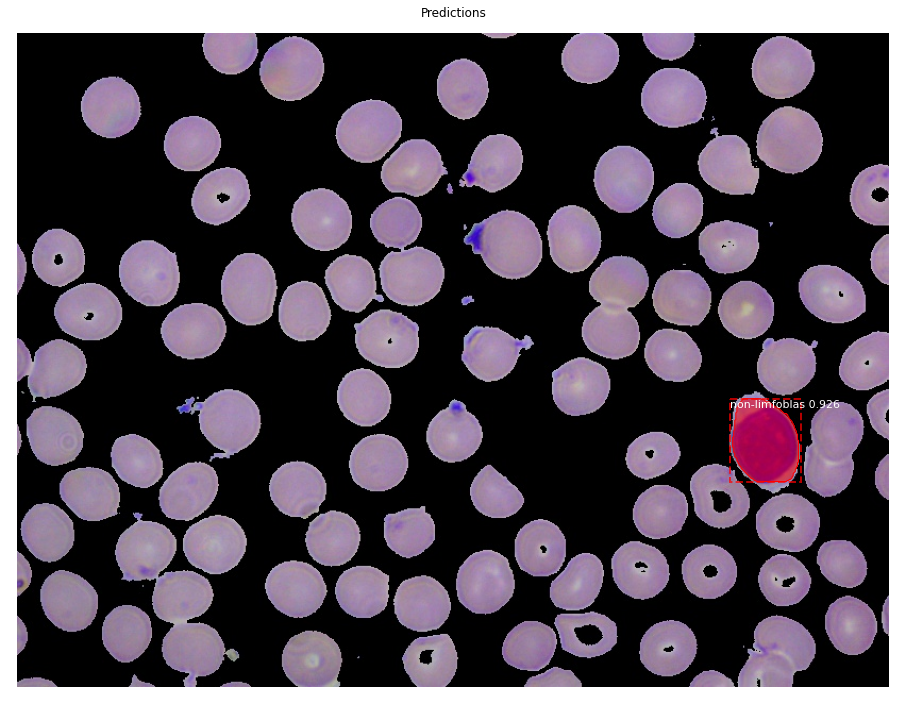

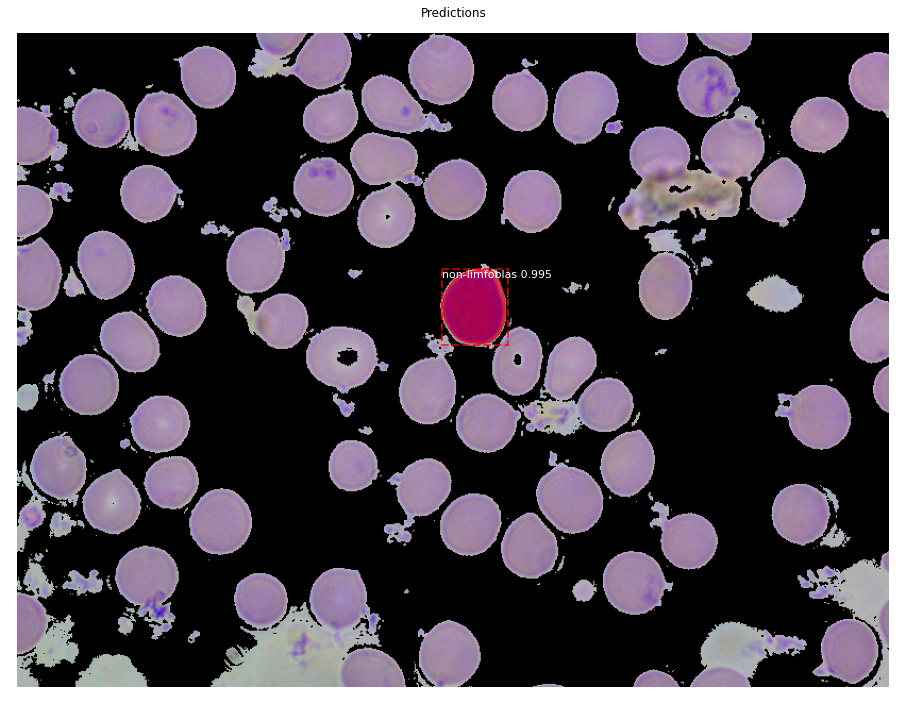

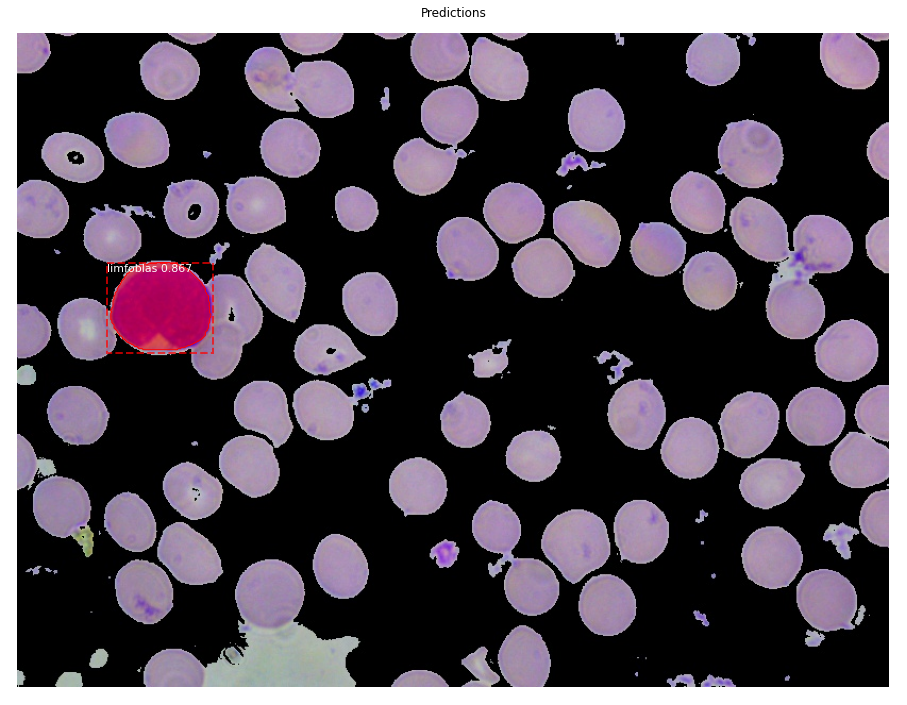

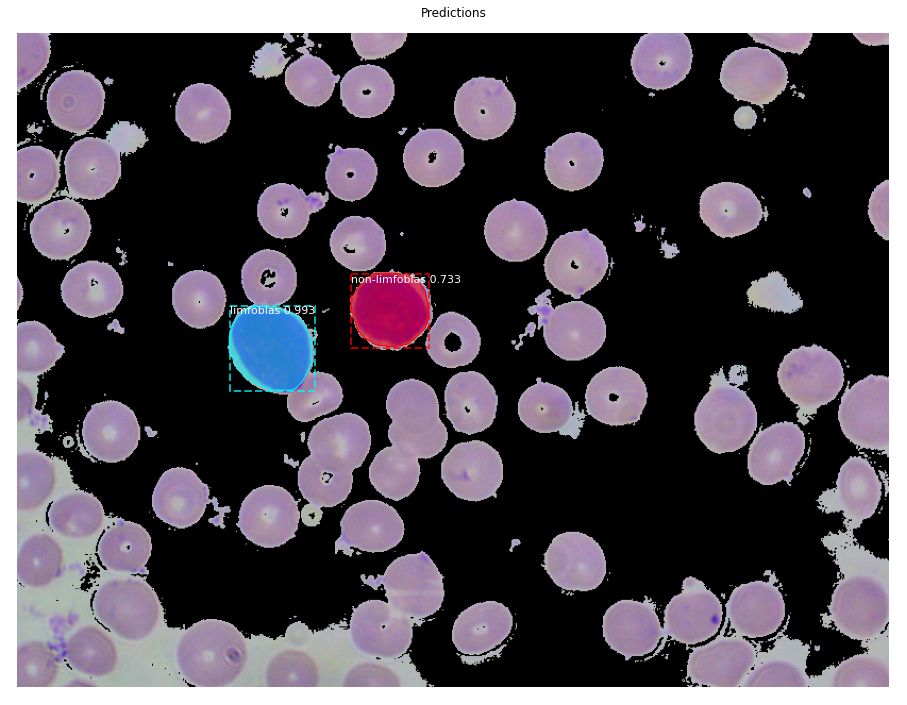

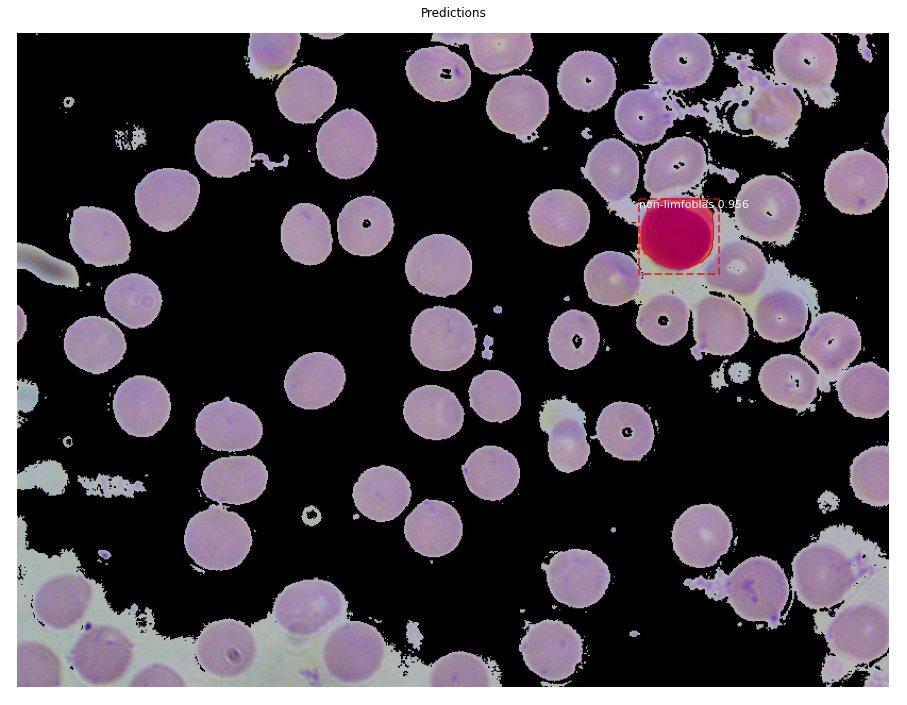

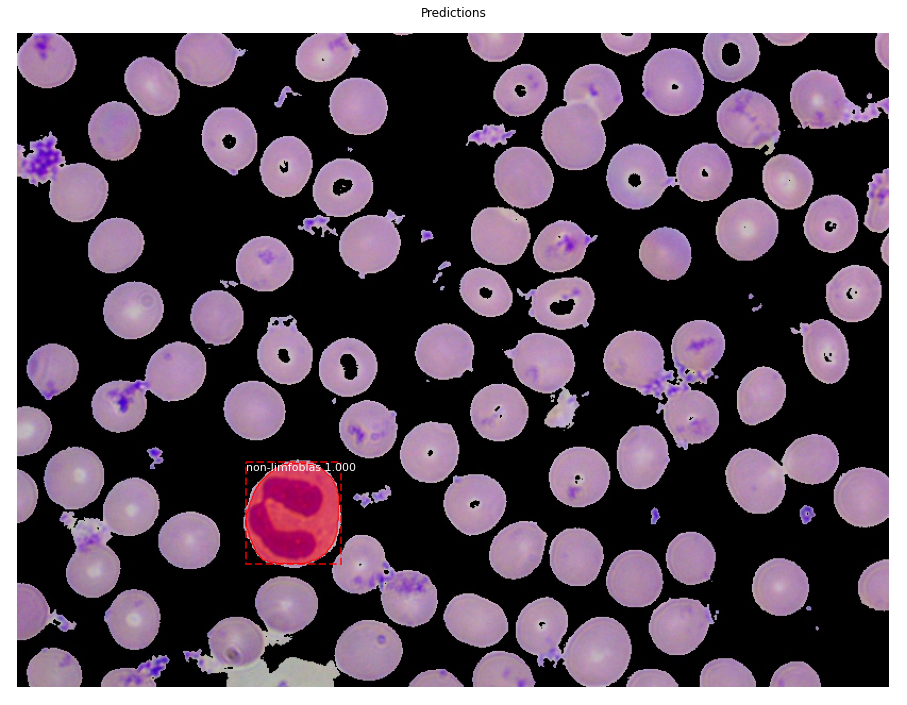

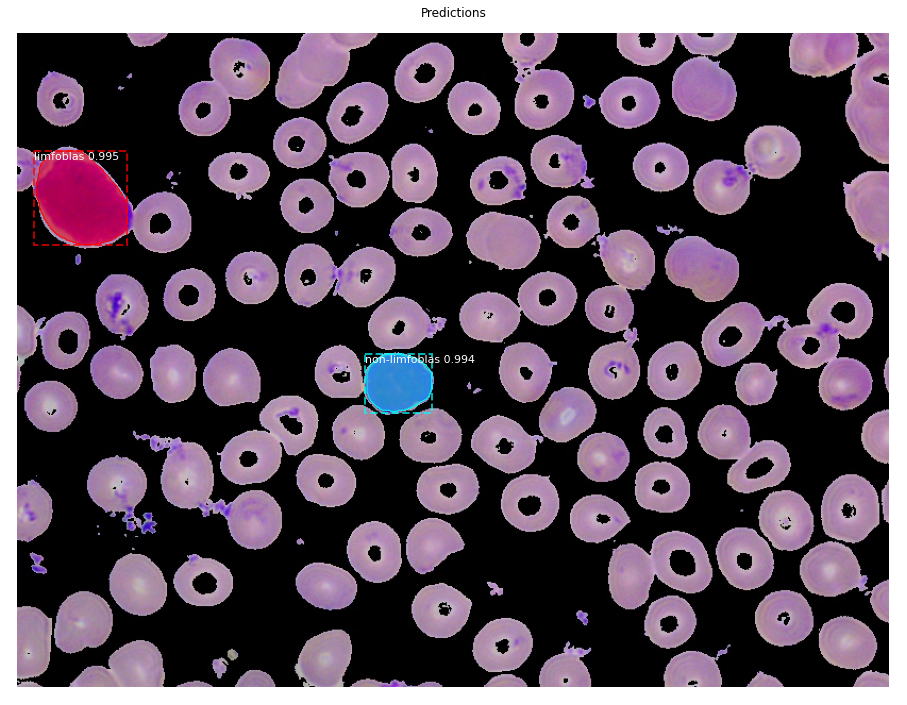

In [106]:
image_path = "val-processed"
save_path = "output\processed\output-demo-nov"
predict(image_path, onlyfiles, save_path)